In [ ]:
!pip install transformers datasets joblib torch scikit-learn matplotlib pytesseract pdfminer.six pillow

!pip install --upgrade transformers datasets --quiet

!pip show transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 77.0 MB/s eta 0:00:00
Name: transformers
Version: 4.55.4
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
!pip install pymupdf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 49.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import joblib
import torch
import logging
import re
import pytesseract
from PIL import Image
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TextClassificationPipeline
from datasets import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import fitz  # PyMuPDF for PDF reading
from xgboost import XGBClassifier

logging.basicConfig(level=logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EMAIL_DATA_PATH = "/content/drive/MyDrive/dataset_physing/email.csv"
SMS_DATA_PATH = "/content/drive/MyDrive/dataset_physing/spam.csv"
CALL_DATA_PATHS = ["/content/drive/MyDrive/dataset_physing/spam_calls.csv", "/content/drive/MyDrive/dataset_physing/Fraudcall.csv"]
WEBSITE_DATA_PATH = "/content/drive/MyDrive/dataset_physing/dataset.csv"


In [ ]:
def load_email_data(path):
    df = pd.read_csv(path)
    df['text'] = df['subject'].astype(str) + " " + df['body'].astype(str)
    df = df.dropna(subset=['text', 'label'])
    return df[['text', 'label']]

In [ ]:
def load_sms_data(path):
    df = pd.read_csv(path, encoding='latin-1')
    df = df.rename(columns={'v1': 'label', 'v2': 'text'})
    return df[['text', 'label']]

In [ ]:
def load_call_data_tabular(paths):
    # Load spam_calls.csv
    df1 = pd.read_csv(paths[0])
    if 'Phone_Number' not in df1.columns or 'Decision' not in df1.columns:
        raise ValueError("spam_calls.csv must contain 'Phone_Number' and 'Decision' columns.")
    df1 = df1.rename(columns={'Phone_Number': 'text', 'Decision': 'label'})
    df1 = df1[['text', 'label']]

    # Load Fraudcall.csv (col 0 = label, col 1 = text)
    df2 = pd.read_csv(paths[1], header=None)
    if df2.shape[1] < 2:
        raise ValueError("Fraudcall.csv must have at least two columns.")
    df2 = df2.rename(columns={0: 'label', 1: 'text'})
    df2 = df2[['text', 'label']]

    # Combine and clean
    combined_df = pd.concat([df1, df2], ignore_index=True)
    combined_df = combined_df.dropna(subset=['text', 'label'])
    combined_df['text'] = combined_df['text'].astype(str)
    combined_df['label'] = combined_df['label'].astype(str).str.lower()

    print(f"📞 Loaded {len(combined_df)} call records.")
    return combined_df


In [ ]:
def load_website_data_tabular(path):
    df = pd.read_csv(path)
    df = df.drop(columns=['index'], errors='ignore')
    df = df.dropna()
    df['label'] = df['Result']
    df = df.drop(columns=['Result'])
    return df

In [ ]:
def extract_links_from_text(text):
    return re.findall(r'https?://\S+|www\.\S+', text)

def load_link_data_from_sources(email_df, sms_df, web_df):
    link_data = []
    for df in [email_df, sms_df, web_df]:
        for _, row in df.iterrows():
            links = extract_links_from_text(row['text'])
            for link in links:
                link_data.append({'text': link, 'label': row['label']})
    return pd.DataFrame(link_data)

In [ ]:
def simulate_pdf_data(dfs, max_samples=200):
    rows = []

    for df in dfs:
        df = df.dropna(subset=['text', 'label']).copy()
        df['label'] = df['label'].astype(str)

        phishing = df[df['label'].str.lower().isin(['spam', 'phish', 'fraud'])].copy()
        ham = df[~df['label'].str.lower().isin(['spam', 'phish', 'fraud'])].copy()

        phishing = phishing.sample(n=min(len(phishing), max_samples // 2), random_state=42)
        ham = ham.sample(n=min(len(ham), max_samples // 2), random_state=42)

        phishing['text'] = phishing['text'].astype(str) + " Please see attached invoice.pdf"
        ham['text'] = ham['text'].astype(str) + " Thank you for reading."

        rows.extend(phishing[['text', 'label']].to_dict('records'))
        rows.extend(ham[['text', 'label']].to_dict('records'))

    pdf_df = pd.DataFrame(rows)
    print(f"📄 Simulated PDF phishing samples: {len(pdf_df)}")
    return pdf_df


In [ ]:
def simulate_image_data(dfs, max_samples=200):
    rows = []

    for df in dfs:
        df = df.dropna(subset=['text', 'label']).copy()
        df['label'] = df['label'].astype(str)

        phishing = df[df['label'].str.lower().isin(['spam', 'phish', 'fraud'])].copy()
        ham = df[~df['label'].str.lower().isin(['spam', 'phish', 'fraud'])].copy()

        phishing = phishing.sample(n=min(len(phishing), max_samples // 2), random_state=42)
        ham = ham.sample(n=min(len(ham), max_samples // 2), random_state=42)

        phishing['text'] = phishing['text'].astype(str) + " View secure content in image.jpg"
        ham['text'] = ham['text'].astype(str) + " Regular message without image."

        rows.extend(phishing[['text', 'label']].to_dict('records'))
        rows.extend(ham[['text', 'label']].to_dict('records'))

    image_df = pd.DataFrame(rows)
    print(f"🖼️ Simulated Image phishing samples: {len(image_df)}")
    return image_df


In [ ]:
def train_sota_model(df, model_name="model"):
    if df.empty:
        print(f"⚠️ Skipping {model_name}: dataset is empty.")
        return {'model': None, 'tokenizer': None, 'label_encoder': None, 'X_test': [], 'y_test': []}

    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['label'])
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_encoded'], test_size=0.2, random_state=42)
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    test_df = pd.DataFrame({'text': X_test, 'label': y_test})

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

    train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
    test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
    args = TrainingArguments(output_dir='./results', num_train_epochs=3, per_device_train_batch_size=16, per_device_eval_batch_size=16, weight_decay=0.01, fp16=True, logging_dir='./logs', logging_steps=50)

    trainer = Trainer(model=model, args=args, train_dataset=train_dataset, eval_dataset=test_dataset)
    trainer.train()

    return {'model': model, 'tokenizer': tokenizer, 'label_encoder': label_encoder, 'X_test': X_test, 'y_test': y_test}

In [ ]:
def train_xgb_model(df, name="XGBoost Model"):
    if df.empty:
        print(f"⚠️ Skipping {name}: dataset is empty.")
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])

    # Drop non-numeric columns (e.g., text)
    X = df.drop(columns=['label'])
    X = X.select_dtypes(include=['int64', 'float64', 'bool'])

    if X.empty:
        print(f"⚠️ Skipping {name}: no valid numeric features.")
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    y = df['label']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize model
    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Print metrics
    print(f"\n📊 {name} Metrics:")
    print(f"Accuracy  : {report['accuracy']:.4f}")
    print(f"Precision : {report['weighted avg']['precision']:.4f}")
    print(f"Recall    : {report['weighted avg']['recall']:.4f}")
    print(f"F1 Score  : {report['weighted avg']['f1-score']:.4f}")

    return {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }


In [ ]:
def compute_test_metrics(model_package, model_name="Model"):
    if len(model_package['X_test']) == 0:
        print(f"⚠️ No test data for {model_name} evaluation.")
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    pipeline = TextClassificationPipeline(
        model=model_package['model'],
        tokenizer=model_package['tokenizer'],
        device=0 if torch.cuda.is_available() else -1
    )

    y_pred = []
    print(f"\n🔍 Running predictions for {model_name} on test set...")
    for text in tqdm(model_package['X_test']):
        result = pipeline(text, truncation=True, max_length=512)[0]
        label_index = int(result['label'].split("_")[-1])
        y_pred.append(label_index)

    acc = accuracy_score(model_package['y_test'], y_pred)
    prec = precision_score(model_package['y_test'], y_pred, average='weighted', zero_division=0)
    rec = recall_score(model_package['y_test'], y_pred, average='weighted', zero_division=0)
    f1 = f1_score(model_package['y_test'], y_pred, average='weighted', zero_division=0)

    print(f"\n📊 {model_name} Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}


In [ ]:
def plot_metrics(metrics_dict):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    for ax, metric in zip(axs.ravel(), ['accuracy', 'precision', 'recall', 'f1']):
        values = [metrics_dict[m].get(metric, 0.0) for m in metrics_dict]
        ax.bar(metrics_dict.keys(), values, color='skyblue')
        ax.set_title(metric.capitalize())
        ax.set_ylim([0, 1])
        ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.suptitle('📊 UniPhish Guardian Model Metrics')
    plt.show()


In [ ]:
def train_uniphish_guardian():
    metrics_summary = {}

    # === Load datasets ===
    email_df = load_email_data(EMAIL_DATA_PATH)
    sms_df = load_sms_data(SMS_DATA_PATH)
    call_df = load_call_data_tabular(CALL_DATA_PATHS)

    web_df = pd.read_csv(WEBSITE_DATA_PATH)
    web_df['text'] = web_df.drop(columns=['Result', 'index'], errors='ignore').astype(str).agg(' '.join, axis=1)
    web_df = web_df.rename(columns={'Result': 'label'})

    link_df = load_link_data_from_sources(email_df, sms_df, web_df)
    pdf_df = simulate_pdf_data([email_df, web_df])
    image_df = simulate_image_data([email_df, web_df])

    # === Print sizes ===
    print("📊 Email samples:", len(email_df))
    print("📊 SMS samples:", len(sms_df))
    print("📊 Call samples:", len(call_df))
    print("📊 Website samples:", len(web_df))
    print("📊 Link samples:", len(link_df))
    print("📊 PDF samples:", len(pdf_df))
    print("📊 Image samples:", len(image_df))

    # === Train each model ===

    print("Training Email Model...")
    email_model = train_sota_model(email_df, model_name="Email")
    metrics_summary['Email'] = compute_test_metrics(email_model, model_name="Email")

    print("Training SMS Model...")
    sms_model = train_sota_model(sms_df, model_name="SMS")
    metrics_summary['SMS'] = compute_test_metrics(sms_model, model_name="SMS")

    print("Training Call Model...")
    if not call_df.empty:
        call_model = train_sota_model(call_df, model_name="Call")
        metrics_summary['Call'] = compute_test_metrics(call_model, model_name="Call")
    else:
        print("⚠️ Skipping Call Model: dataset is empty.")
        call_model = None
        metrics_summary['Call'] = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


    print("Training Website Model...")
    website_model = train_xgb_model(web_df, name="Website")
    metrics_summary['Website'] = website_model


    print("Training Link Model...")
    if not link_df.empty:
        link_model = train_sota_model(link_df, model_name="Link")
        metrics_summary['Link'] = compute_test_metrics(link_model, model_name="Link")
    else:
        print("⚠️ Skipping Link Model: dataset is empty.")
        link_model = None
        metrics_summary['Link'] = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


    print("Training PDF Model...")
    if not pdf_df.empty:
        pdf_model = train_sota_model(pdf_df, model_name="PDF")
        metrics_summary['PDF'] = compute_test_metrics(pdf_model, model_name="PDF")
    else:
        print("⚠️ Skipping PDF Model: dataset is empty.")
        pdf_model = None
        metrics_summary['PDF'] = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


    print("Training Image Model...")
    if not image_df.empty:
        image_model = train_sota_model(image_df, model_name="Image")
        metrics_summary['Image'] = compute_test_metrics(image_model, model_name="Image")
    else:
        print("⚠️ Skipping Image Model: dataset is empty.")
        image_model = None
        metrics_summary['Image'] = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


    # === Plot summary ===
    plot_metrics(metrics_summary)
    print("✅ Training Complete")

    # ==================== OVERALL METRICS ====================
    print("\n📦 Computing overall metrics across all datasets...")

    all_y_true = []
    all_y_pred = []

    for model_name, model_pack in [
        ('Email', email_model), ('SMS', sms_model), ('Call', call_model),
        ('Link', link_model), ('PDF', pdf_model), ('Image', image_model)
    ]:
        if model_pack is None:
            continue

        pipeline = TextClassificationPipeline(
            model=model_pack['model'],
            tokenizer=model_pack['tokenizer'],
            device=0 if torch.cuda.is_available() else -1
        )

        for text, true_label in zip(model_pack['X_test'], model_pack['y_test']):
            result = pipeline(text, truncation=True, max_length=512)[0]
            pred_label = int(result['label'].split("_")[-1])
            all_y_true.append(true_label)
            all_y_pred.append(pred_label)

    # Compute final metrics
    if all_y_true and all_y_pred:
        overall_acc = accuracy_score(all_y_true, all_y_pred)
        overall_prec = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
        overall_rec = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
        overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted', zero_division=0)

        print(f"\n🌐 OVERALL SYSTEM PERFORMANCE")
        print(f"Overall Accuracy : {overall_acc:.4f}")
        print(f"Overall Precision: {overall_prec:.4f}")
        print(f"Overall Recall   : {overall_rec:.4f}")
        print(f"Overall F1 Score : {overall_f1:.4f}")
    else:
        print("⚠️ Overall evaluation skipped: no valid predictions.")

    return email_model, sms_model, call_model, website_model, link_model, pdf_model, image_model, metrics_summary

📞 Loaded 5973 call records.
📄 Simulated PDF phishing samples: 200
🖼️ Simulated Image phishing samples: 200
📊 Email samples: 29767
📊 SMS samples: 5572
📊 Call samples: 5973
📊 Website samples: 11055
📊 Link samples: 106
📊 PDF samples: 200
📊 Image samples: 200
Training Email Model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/23813 [00:00<?, ? examples/s]

Map:   0%|          | 0/5954 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sayantikasadhukhan62 (sayantikasadhukhan62-university-of-engineering-and-manag) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.397600
100,0.132100
150,0.161900
200,0.034900
250,0.157300
300,0.134400
350,0.105400
400,0.077200
450,0.066700
500,0.067100


Device set to use cuda:0



🔍 Running predictions for Email on test set...


100%|██████████| 5954/5954 [01:43<00:00, 57.38it/s]



📊 Email Metrics:
Accuracy  : 0.9951
Precision : 0.9951
Recall    : 0.9951
F1 Score  : 0.9951
Training SMS Model...


Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.192100
100,0.106200
150,0.126400
200,0.048500
250,0.054800
300,0.046500
350,0.020900
400,0.021000
450,0.044300
500,0.038100


Device set to use cuda:0



🔍 Running predictions for SMS on test set...


100%|██████████| 1115/1115 [00:16<00:00, 69.51it/s]



📊 SMS Metrics:
Accuracy  : 0.9928
Precision : 0.9928
Recall    : 0.9928
F1 Score  : 0.9928
Training Call Model...


Map:   0%|          | 0/4778 [00:00<?, ? examples/s]

Map:   0%|          | 0/1195 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.334500
100,0.203900
150,0.175900
200,0.132600
250,0.133400
300,0.068800
350,0.064000
400,0.098400
450,0.064100
500,0.063500


Device set to use cuda:0



🔍 Running predictions for Call on test set...


100%|██████████| 1195/1195 [00:17<00:00, 67.50it/s]



📊 Call Metrics:
Accuracy  : 0.9833
Precision : 0.9834
Recall    : 0.9833
F1 Score  : 0.9827
Training Website Model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:51:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Website Metrics:
Accuracy  : 0.9616
Precision : 0.9616
Recall    : 0.9616
F1 Score  : 0.9615
Training Link Model...


Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Device set to use cuda:0



🔍 Running predictions for Link on test set...


100%|██████████| 22/22 [00:00<00:00, 70.54it/s]



📊 Link Metrics:
Accuracy  : 1.0000
Precision : 1.0000
Recall    : 1.0000
F1 Score  : 1.0000
Training PDF Model...


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Device set to use cuda:0



🔍 Running predictions for PDF on test set...


100%|██████████| 40/40 [00:00<00:00, 47.07it/s]



📊 PDF Metrics:
Accuracy  : 0.7000
Precision : 0.7574
Recall    : 0.7000
F1 Score  : 0.6895
Training Image Model...


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Device set to use cuda:0



🔍 Running predictions for Image on test set...


100%|██████████| 40/40 [00:00<00:00, 47.52it/s]



📊 Image Metrics:
Accuracy  : 0.6250
Precision : 0.4964
Recall    : 0.6250
F1 Score  : 0.5484


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


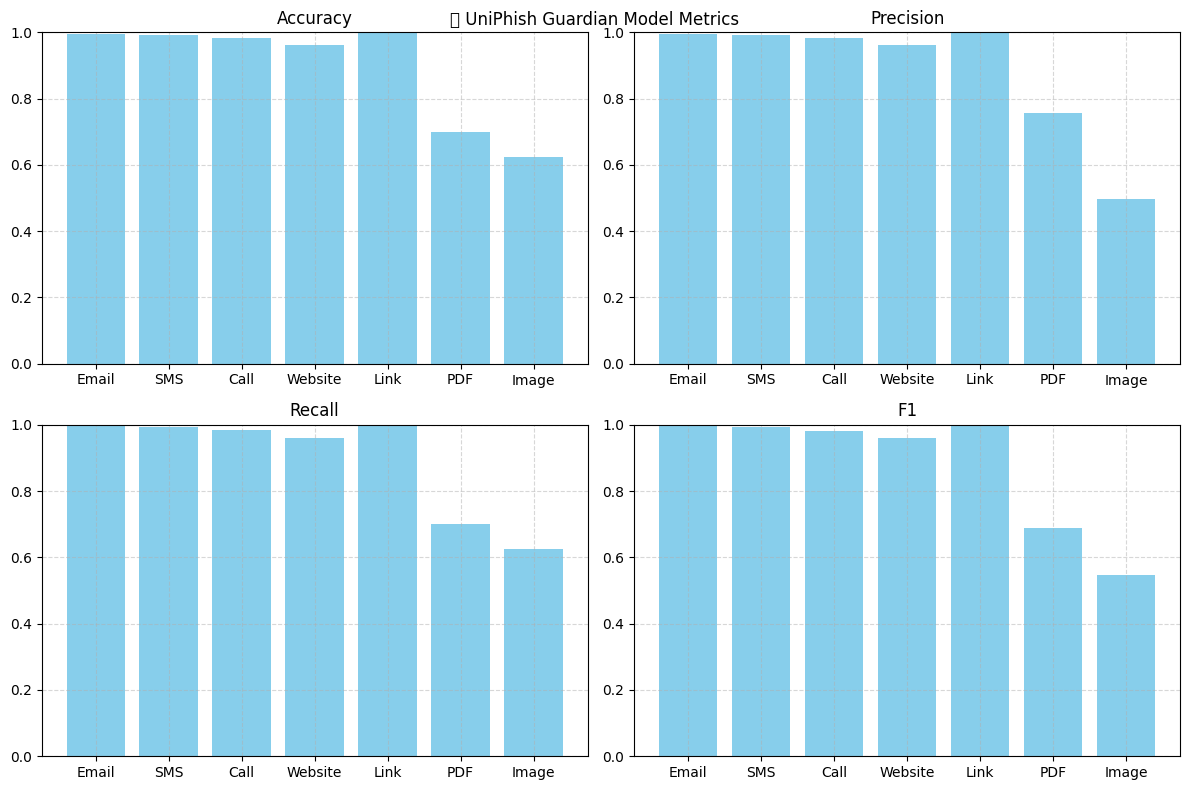

Device set to use cuda:0


✅ Training Complete

📦 Computing overall metrics across all datasets...


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0



🌐 OVERALL SYSTEM PERFORMANCE
Overall Accuracy : 0.9897
Overall Precision: 0.9909
Overall Recall   : 0.9897
Overall F1 Score : 0.9901


In [ ]:


# ==================== SAVE FINAL MODEL ====================
email_model, sms_model, call_model, website_model, link_model, pdf_model, image_model, metrics_summary = train_uniphish_guardian()


